Steps done in this Project :
      

*   Dataset Loading

*   Importing Necessary Packages

*   Storing the Dataset in Array and Conversion to Grayscale Images

*   Shuffling of Dataset

*   Normalisation of Original Dataset

*   Binarization of Original Dataset

*   Sigma Guard Algorithm Definition

*   Entropy Fluctuation Patrol Algorithm Definition

*   Passing Data to the Sigma Guard Algorithm
*   Passing Data to EF Patrol Algorithm


*   Normalization Definition


*   Normalization of Algorithm Outputs


*   Context Sensitive Data Enrichment (CSDE) Algorithm Definition


*   Passing into CSDE Algorithm


*   Further Updation of EF Patrol Images


*   Libraries of S2Net Model


*   Reshaping into 3D Array


*   Train and Test Spliting

*   S2Net Model Definition

*   S2Net Model Compilation

*   Output of EF Patrol Passing into the Model

*   Output of Sigma Guard Passing into the Model

*   Model Evaluation of EF Patrol

*   Model Evaluation of Sigma Guard
*   Save the Models to the Drive


*   Confusion Matrix & Classification Report of EF Patrol - S2Net


*   Confusion Matrix & Classification Report of Sigma Guard - S2Net


*   SSIM, PSNR, Histogram Intersection Metrics Evaluation for EF Patrol Vs Sigma Guard


Mounting the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


SCD Dataset

In [2]:
path = "/content/drive/MyDrive/SCD1000/SCDPos"
npath = "/content/drive/MyDrive/SCD1000/SCDNeg"

Importing Necessary Packages

In [2]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, Adagrad
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

Storing the Dataset in Array and Conversion to Grayscale Images

In [4]:
data = []
gdata=[]
y = []
for img in os.listdir(path):
    try:
        oimage = cv2.imread(os.path.join(path, img))
        if oimage is not None:
          data.append(oimage)
        y.append(1)
    except Exception as e:
        print(e)

for img in os.listdir(npath):
    try:
        oimage = cv2.imread(os.path.join(npath, img))
        if oimage is not None:
          data.append(oimage)
        y.append(0)
    except Exception as e:
        print(e)

for i in data:
    grayscale_image = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    img_arr = cv2.resize(grayscale_image, (256, 256))
    gdata.append(img_arr)

len(gdata)

2000

Shuffling of Dataset

In [ ]:
import random

# Combine gdata and Y into a list of tuples
combined_data = list(zip(gdata, y))

# Shuffle the combined data
random.shuffle(combined_data)

# Unpack the shuffled data back into gdata and Y
gdata, y = zip(*combined_data)

len(gdata)

In [7]:
import pickle

# Path to save the variable file in Google Drive
file_path = '/content/drive/MyDrive/my_gdata.pkl'

# Load the variable from the pickle file
with open(file_path, 'rb') as f:
    gdata = pickle.load(f)

# Path to save the variable file in Google Drive
file_path = '/content/drive/MyDrive/my_ydata.pkl'

# Load the variable from the pickle file
with open(file_path, 'rb') as f:
    y = pickle.load(f)


Normalisation of Original Image

In [4]:
ngdata=[]
Mg=[]
for i in gdata:
    min_val = np.min(i)
    max_val = np.max(i)
    normalized_gray_image = (i - min_val) / (max_val - min_val)
    mg=np.mean(normalized_gray_image)
    ngdata.append(normalized_gray_image)
    Mg.append(mg)

len(ngdata)

ngdata1=copy.deepcopy(ngdata)
ngdata2=copy.deepcopy(ngdata)
ngdata3=copy.deepcopy(ngdata)
ngdata4=copy.deepcopy(ngdata)

Binarization

In [5]:
bindata=[]
for i in ngdata:
    binary_image = np.where(i >= mg, 1, 0)
    bindata.append(binary_image)

Sigma Guard Algorithm

In [5]:
def calculate_standard_deviation(image, window_size=9, stride=1):
    height, width = image.shape
    std_dev_map = np.zeros((height, width))
    iimg=[]
    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            window = image[y:y + window_size, x:x + window_size]

            # Manual standard deviation calculation
            mean = np.mean(window)
            std_dev = np.sqrt(np.mean((window - mean) ** 2))

            std_dev_map[y:y + window_size, x:x + window_size] += std_dev

    for img in std_dev_map:
        Inverted_image=255-img
        iimg.append(Inverted_image)

    return iimg

Entropy Fluctuation Patrol Algorithm

In [6]:
def calculate_entropy():
  edata=[]
  a=0
  for i in gdata:
    print(f"Processing Image {a + 1} ...")
    a=a+1
    inverted_image = 255-i
    radius = 1
    epsilon = 1e-8
    padded_image = np.pad(inverted_image, pad_width=radius, mode='constant', constant_values=0)
    h, w = inverted_image.shape
    entropy_matrix = np.zeros((h, w), dtype=np.float64)
    l = [-1, 0, 1]

    for i in range(1, h + 1):
        for j in range(1, w + 1):
            local_sum = 0.0
            for p in l:
                for q in l:
                    intensity = padded_image[i + p, j + q]
                    if intensity > 0:
                        local_sum += intensity * np.log(intensity + epsilon)

            entropy_matrix[i - 1, j - 1] = -local_sum
    edata.append(entropy_matrix)
  return edata


Passing Data to the Sigma Guard Algorithm

In [14]:
import time
StDev = []
start_time = time.time()

for i, img in enumerate(gdata):
    result_map = calculate_standard_deviation(img)
    StDev.append(result_map)
    print(f"Processing Image {i + 1} ...")
    # Print progress and time elapsed for every 100 images
    if (i + 1) % 100 == 0:
        elapsed_time_seconds = time.time() - start_time
        elapsed_time_minutes = elapsed_time_seconds / 60  # Convert seconds to minutes
        print(f"Processed {i + 1} images. Time Taken : {elapsed_time_minutes:.2f} minutes")

total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds / 60  # Convert total time to minutes
print(f"Total time taken to process {len(gdata)} images: {total_time_minutes:.2f} minutes")


Processing Image 1 ...
Processing Image 2 ...
Processing Image 3 ...
Processing Image 4 ...
Processing Image 5 ...
Processing Image 6 ...
Processing Image 7 ...
Processing Image 8 ...
Processing Image 9 ...
Processing Image 10 ...
Processing Image 11 ...
Processing Image 12 ...
Processing Image 13 ...
Processing Image 14 ...
Processing Image 15 ...
Processing Image 16 ...
Processing Image 17 ...
Processing Image 18 ...
Processing Image 19 ...
Processing Image 20 ...
Processing Image 21 ...
Processing Image 22 ...
Processing Image 23 ...
Processing Image 24 ...
Processing Image 25 ...
Processing Image 26 ...
Processing Image 27 ...
Processing Image 28 ...
Processing Image 29 ...
Processing Image 30 ...
Processing Image 31 ...
Processing Image 32 ...
Processing Image 33 ...
Processing Image 34 ...
Processing Image 35 ...
Processing Image 36 ...
Processing Image 37 ...
Processing Image 38 ...
Processing Image 39 ...
Processing Image 40 ...
Processing Image 41 ...
Processing Image 42 ...
P

In [6]:
import pickle

# Path to save the variable file in Google Drive
file_path = '/content/drive/MyDrive/my_sigmavariable.pkl'

# Load the variable from the pickle file
with open(file_path, 'rb') as f:
    StDev = pickle.load(f)


Passing Data to EF Patrol Algorithm

In [16]:
import time
start_time = time.time()
edata=calculate_entropy()
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds / 60  # Convert total time to minutes
print(f"Total time taken to process {len(gdata)} images: {total_time_minutes:.2f} minutes")

Processing Image 1 ...
Processing Image 2 ...
Processing Image 3 ...
Processing Image 4 ...
Processing Image 5 ...
Processing Image 6 ...
Processing Image 7 ...
Processing Image 8 ...
Processing Image 9 ...
Processing Image 10 ...
Processing Image 11 ...
Processing Image 12 ...
Processing Image 13 ...
Processing Image 14 ...
Processing Image 15 ...
Processing Image 16 ...
Processing Image 17 ...
Processing Image 18 ...
Processing Image 19 ...
Processing Image 20 ...
Processing Image 21 ...
Processing Image 22 ...
Processing Image 23 ...
Processing Image 24 ...
Processing Image 25 ...
Processing Image 26 ...
Processing Image 27 ...
Processing Image 28 ...
Processing Image 29 ...
Processing Image 30 ...
Processing Image 31 ...
Processing Image 32 ...
Processing Image 33 ...
Processing Image 34 ...
Processing Image 35 ...
Processing Image 36 ...
Processing Image 37 ...
Processing Image 38 ...
Processing Image 39 ...
Processing Image 40 ...
Processing Image 41 ...
Processing Image 42 ...
P

In [6]:
import pickle

# Path to save the variable file in Google Drive
file_path = '/content/drive/MyDrive/my_efvariable.pkl'

# Load the variable from the pickle file
with open(file_path, 'rb') as f:
    edata = pickle.load(f)


Normalization

In [7]:
def normalize(arrval):
  Norm=[]
  Meanvalue=[]
  for img in arrval:
    min_val = np.min(img)
    max_val = np.max(img)
    niimg = (img - min_val) / (max_val - min_val)
    ms=np.mean(niimg)
    Norm.append(niimg)
    Meanvalue.append(ms)
  return Norm,Meanvalue

Normalisation of Algorithm Outputs

In [8]:
nedata,ne_meanval=normalize(edata)
NStDev,Ms=normalize(StDev)

Context Sensitive Data Enrichment (CSDE) Algorithm

In [9]:
def update_image(I, Me, me, mg):
    H, W = I.shape

    for i in range(H):
        for j in range(W):
            if Me[i][j] < me:
                if I[i][j] < mg:
                    I[i][j] *= Me[i][j]
                else:
                    temp = I[i][j] * (1 + me - Me[i][j])
                    I[i][j] = min(1, temp)
            else:
                temp = I[i][j] * (1 + Me[i][j] - me)
                I[i][j] = min(1, temp)

    return I

Passing into CSDE Algorithm

In [10]:
import pickle

ef_img=[]


for i in range(0,len(gdata)):
    ef_img.append(update_image(ngdata[i],nedata[i],ne_meanval[i],Mg[i]))

# Path to save the variable file in Google Drive
file_path = '/content/drive/MyDrive/csde_efvariable.pkl'

# Save the variable to Google Drive
with open(file_path, 'wb') as file:
    pickle.dump(ef_img, file)

In [17]:

# Path to save the variable file in Google Drive
file_path = '/content/drive/MyDrive/csde_efvariable.pkl'

# Load the variable from the pickle file
with open(file_path, 'rb') as f:
    ef_img = pickle.load(f)

In [11]:
import pickle
sg_img=[]

for i in range(0,len(gdata)):
    sg_img.append(update_image(ngdata1[i],NStDev[i],Ms[i],Mg[i]))

# Path to save the variable file in Google Drive
file_path = '/content/drive/MyDrive/csde_sgvariable.pkl'

# Save the variable to Google Drive
with open(file_path, 'wb') as file:
    pickle.dump(sg_img, file)


Clear Crack Algorithm

In [14]:
def clearcrack(nd,ad):
  esimg=[]
  for a in range(0,len(gdata)):
    uimg=nd[a]
    h,w=uimg.shape
    bimg=bindata[a]
    image=ad[a]
    for i in range(h):
        for j in range(w):
            if bimg[i][j]==0:
                uimg[i][j]=image[i][j]
    esimg.append(uimg)
  return esimg

Passing the Outputs of CSDE to Clear Crack

In [18]:
final_ef_img=clearcrack(ngdata2,ef_img)


In [15]:
final_sg_img=clearcrack(ngdata3,sg_img)

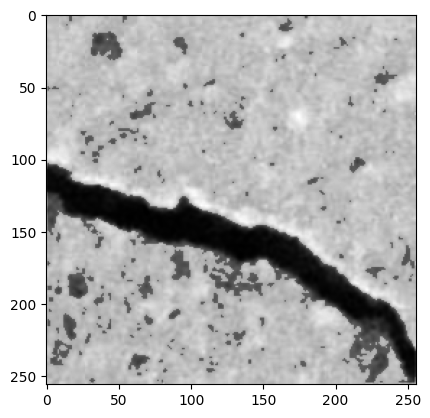

In [24]:
plt.imshow(final_ef_img[236],cmap='gray')

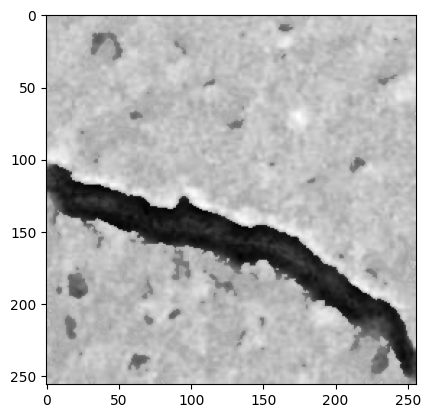

In [25]:
plt.imshow(final_sg_img[236],cmap='gray')

In [3]:
import pickle

# Path to save the variable file in Google Drive
file_path = '/content/drive/MyDrive/finalefvariable.pkl'

# Load the variable from the pickle file
with open(file_path, 'rb') as f:
    final_ef_img = pickle.load(f)

In [4]:
import pickle

# Path to save the variable file in Google Drive
file_path = '/content/drive/MyDrive/finalsgvariable.pkl'

# Load the variable from the pickle file
with open(file_path, 'rb') as f:
    final_sg_img = pickle.load(f)

Libraries of S2Net Model

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.models import load_model, Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2

Reshaping into 3D Array

In [8]:
x1=final_ef_img
x2=final_sg_img
img_size=256
x1 = np.array(x1).reshape(-1, img_size, img_size, 1)   # x1 - EF Patrol
x2= np.array(x2).reshape(-1, img_size, img_size, 1)   # x2 - Sigma Guard
y1 = np.array(y)
y2 = copy.deepcopy(y1)
len(x1)
len(x2)

2000

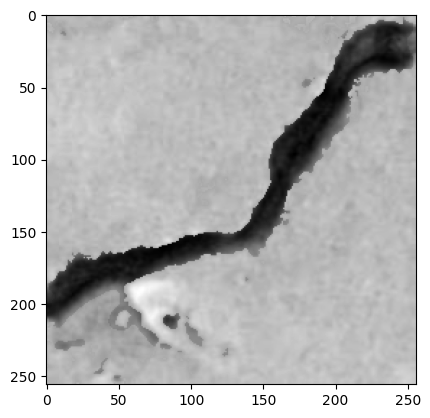

In [12]:
plt.imshow(x2[999],cmap='gray')

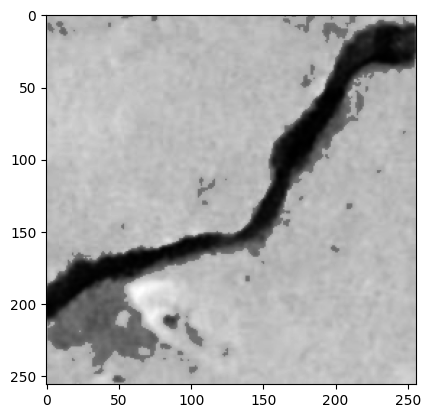

In [11]:
plt.imshow(x1[999],cmap='gray')

S2Net Model Definition

In [13]:
class S2Net:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.autoencoder = self.build_autoencoder()
        self.ef_model = self.build_classifier()
        self.sg_model = self.build_classifier()

    def build_autoencoder(self):
        encoder_input = Input(shape=self.input_shape)
        encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
        encoder = MaxPooling2D((2, 2), padding='same')(encoder)
        encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
        encoder_output = MaxPooling2D((2, 2), padding='same')(encoder)

        decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_output)
        decoder = UpSampling2D((2, 2))(decoder)
        decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
        decoder = UpSampling2D((2, 2))(decoder)
        decoder_output = Conv2D(1, (3, 3), activation='tanh', padding='same')(decoder)

        autoencoder = Model(encoder_input, decoder_output)
        return autoencoder

    def build_classifier(self):
        model = Sequential()
        model.add(self.autoencoder)
        model.add(Conv2D(64, 3, padding="same", activation="relu"))
        model.add(MaxPooling2D())

        model.add(Conv2D(64, 3, padding="same", activation="relu"))
        model.add(MaxPooling2D())

        model.add(Conv2D(128, 3, padding="same", activation="relu"))
        model.add(MaxPooling2D())

        model.add(Flatten())
        model.add(Dense(256, activation="relu"))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Dense(2, activation="softmax"))

        return model

# Example usage
input_shape = (256, 256, 1)
s2net = S2Net(input_shape)


Model Architecture Display

In [14]:
!pip install visualkeras
!pip install pydot
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.7 MB/s eta 0:00:00


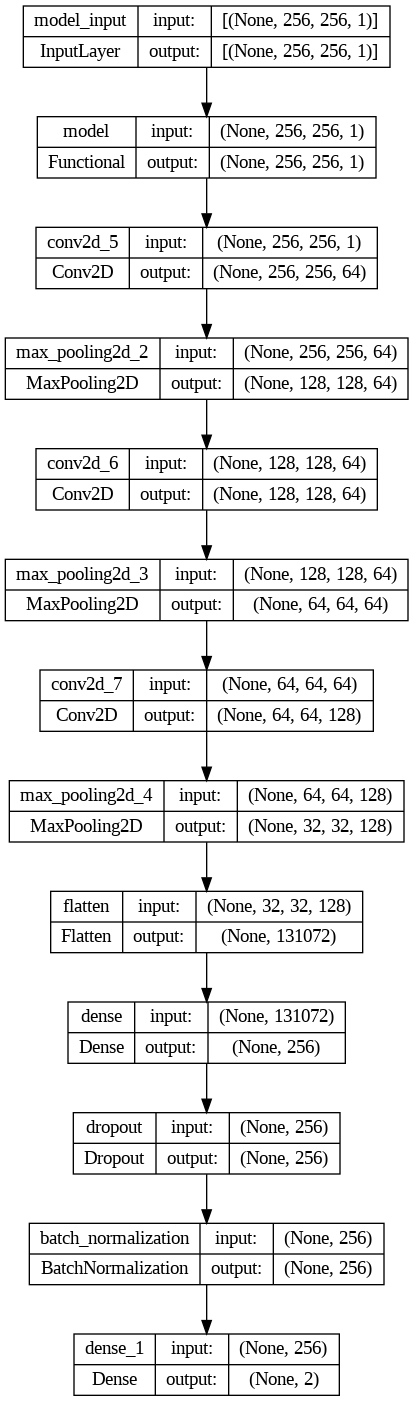

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(s2net.ef_model, to_file='s2model_architecture.png', show_shapes=True, show_layer_names=True)

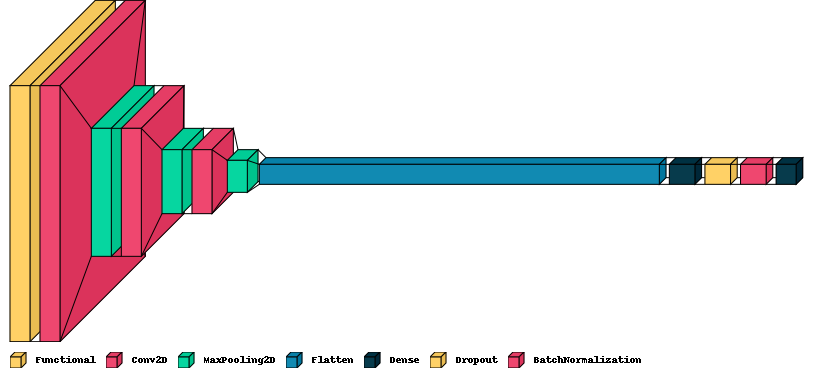

In [16]:
from IPython.display import display
from visualkeras import layered_view

descriptions = [
    "Input (227x227x1)",
    "Conv2D (32 filters, 3x3, activation='relu', padding='same')",
    "MaxPooling2D (2x2, padding='same')",
    "Conv2D (64 filters, 3x3, activation='relu', padding='same')",
    "MaxPooling2D (2x2, padding='same')",
    "Conv2D (64 filters, 3x3, activation='relu', padding='same')",
    "UpSampling2D (2x2)",
    "Conv2D (32 filters, 3x3, activation='relu', padding='same')",
    "UpSampling2D (2x2)",
    "Conv2D (1 filter, 3x3, activation='tanh', padding='same')",
    "Conv2D (64 filters, 3x3, activation='relu', padding='same')",
    "MaxPooling2D",
    "Conv2D (64 filters, 3x3, activation='relu', padding='same')",
    "MaxPooling2D",
    "Conv2D (128 filters, 3x3, activation='relu', padding='same')",
    "MaxPooling2D",
    "Flatten",
    "Dense (256 units, activation='relu')",
    "Dropout (0.5)",
    "BatchNormalization",
    "Dense (2 units, activation='softmax')",
    "Output (2)"
]

# Assuming 'model' is your Keras model
display(layered_view(s2net.ef_model, legend=descriptions, to_file='s2arch.png', scale_xy=1))

Output of EF Patrol Passing into the Model

In [ ]:
# Assuming x and y are your complete dataset and labels
x1_train, x1_temp, y1_train, y1_temp = train_test_split(x1, y1, test_size=0.2, random_state=42,shuffle=False)
x1_val, x1_test, y1_val, y1_test = train_test_split(x1_temp, y1_temp, test_size=0.5, random_state=42,shuffle=False)

opt = Adam(learning_rate=1e-5)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit model 1 for Algorithm 1
s2net.ef_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ef_history = s2net.ef_model.fit(
    x1_train, y1_train, batch_size=32,
    epochs=20,  # Increase the number of epochs
    validation_data=(x1_val, y1_val),
    callbacks=[early_stopping]
)
s2net.ef_model.summary()

Output of Sigma Guard Passing into the Model

In [ ]:
# Assuming x and y are your complete dataset and labels
x2_train, x2_temp, y2_train, y2_temp = train_test_split(x2, y2, test_size=0.2, random_state=42,shuffle=False)
x2_val, x2_test, y2_val, y2_test = train_test_split(x2_temp, y2_temp, test_size=0.5, random_state=42, shuffle=False)

opt = Adam(learning_rate=1e-5)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit model 2 for Algorithm 2
s2net.sg_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

sg_history = s2net.sg_model.fit(
    x2_train, y2_train, batch_size=32,
    epochs=20,  # Increase the number of epochs
    validation_data=(x2_val, y2_val),
    callbacks=[early_stopping]
)
s2net.sg_model.summary()

Model Evaluation of EF Patrol

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ef_history.history['accuracy'])
plt.plot(ef_history.history['val_accuracy'])
plt.title('EF Patrol - S2Net Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ef_history.history['loss'])
plt.plot(ef_history.history['val_loss'])
plt.title('EF Patrol - S2Net Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# Evaluate the model on the test set
ef_test_loss, ef_test_accuracy = s2net.ef_model.evaluate(x1_test, y1_test, verbose=1)
print("EF Patrol - S2Net Test Accuracy: {:.2f}%".format(ef_test_accuracy * 100))


Model Evaluation of Sigma Guard

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sg_history.history['accuracy'])
plt.plot(sg_history.history['val_accuracy'])
plt.title('Sigma Guard - S2Net Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(sg_history.history['loss'])
plt.plot(sg_history.history['val_loss'])
plt.title('Sigma Guard - S2Net Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# Evaluate the model on the test set
sg_test_loss, sg_test_accuracy = s2net.sg_model.evaluate(x2_test, y2_test, verbose=1)
print("Sigma Guard - S2Net Test Accuracy: {:.2f}%".format(sg_test_accuracy * 100))


Save the Model to the Drive

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save the final fold model to Google Drive
s2net.ef_model.save("/content/drive/MyDrive/ef-model1.h5")
s2net.ef_model.save("/content/drive/MyDrive/ef-model2.h5")

# Save the final fold model to Google Drive
s2net.sg_model.save("/content/drive/MyDrive/sg-model1.h5")
s2net.sg_model.save("/content/drive/MyDrive/sg-model2.h5")

Confusion Matrix & Classification Report of EF Patrol - S2Net

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'best_model' is your trained model
# Assuming 'x_test' and 'y_test' are your test data
y_pred_probs1 = s2net.ef_model.predict(x1_test)

# Extract predicted classes using argmax
y_pred_classes1 = y_pred_probs1.argmax(axis=1)
y_true_classes1 = y1_test.astype(int)



# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes1, y_pred_classes1))

# Print confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_true_classes1, y_pred_classes1)
print(conf_matrix)


Confusion Matrix & Classification Report of Sigma Guard - S2Net

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'best_model' is your trained model
# Assuming 'x_test' and 'y_test' are your test data
y_pred_probs2 = s2net.sg_model.predict(x2_test)

# Extract predicted classes using argmax
y_pred_classes2 = y_pred_probs2.argmax(axis=1)
y_true_classes2 = y2_test.astype(int)



# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes2, y_pred_classes2))

# Print confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_true_classes2, y_pred_classes2)
print(conf_matrix)


Structural Similarity Index Measure (SSIM) Metric Evaluation

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

ef_ssim=[]
for i in range(0,len(data)):
    ssimval = ssim(ngdata4[i], final_ef_img[i], data_range=1)
    ef_ssim.append(ssimval)

sg_ssim=[]
for i in range(0,len(data)):
    ssimval = ssim(ngdata4[i], final_sg_img[i], data_range=1)
    sg_ssim.append(ssimval)

ef_sum=0
sg_sum=0
for i in ef_ssim:
    ef_sum=ef_sum+i
for j in sg_ssim:
    sg_sum=sg_sum+j

ef_ssim_res=ef_sum/len(data)
sg_ssim_res=sg_sum/len(data)

print(f"EF Patrol Algorithm. SSIM : {ef_ssim_res:.2f}")
print(f"Sigma Gaurd Algorithm. SSIM : {sg_ssim_res:.2f}")

if sg_ssim_res > ef_ssim_res:
    print("Sigma Guard Algorithm is better then EF Patrol Algorithm")
else:
    print("EF_Patrol Algorithm is better then Sigma Gaurd Algorithm")


Histogram - Intersection Metric Evaluation

Histogram Intersection - EF Patrol

In [ ]:
sum=0
for i in range(0,len(data)):
      ng_scaled = np.uint8(ngdata1[i] * 255)
      ef_scaled = np.uint8(final_ef_img[i] * 255)

      # Compute histograms
      histogram_original = cv2.calcHist([ng_scaled], [0], None, [256], [0, 256])
      histogram_ef = cv2.calcHist([ef_scaled], [0], None, [256], [0, 256])

      # Normalize histograms
      cv2.normalize(histogram_original, histogram_original, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
      cv2.normalize(histogram_ef, histogram_ef, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

      # Compute intersection
      intersection_metric = cv2.compareHist(histogram_original, histogram_ef, cv2.HISTCMP_INTERSECT)
      sum+=intersection_metric

print(sum)
print("Intersection Metric:", sum/len(data))


Histogram Intersection - Sigma Guard

In [ ]:
sum1=0
for i in range(0,len(data)):
      ng_scaled = np.uint8(ngdata1[i] * 255)
      sg_scaled = np.uint8(final_sg_img[i] * 255)

      # Compute histograms
      histogram_original = cv2.calcHist([ng_scaled], [0], None, [256], [0, 256])
      histogram_sg = cv2.calcHist([sg_scaled], [0], None, [256], [0, 256])

      # Normalize histograms
      cv2.normalize(histogram_original, histogram_original, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
      cv2.normalize(histogram_sg, histogram_sg, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

      # Compute intersection
      intersection_metric1 = cv2.compareHist(histogram_original, histogram_sg, cv2.HISTCMP_INTERSECT)
      sum1+=intersection_metric1

print(sum1)
print("Intersection Metric:", sum1/len(data))


Histogram Intersection Result

In [ ]:
print("Histogram - Intersection Result : ")
if intersection_metric1 > intersection_metric:
    print("Sigma Guard Algorithm is better then EF Patrol Algorithm ")
else:
    print("EF_Patrol Algorithm is better then Sigma Gaurd Algorithm")


Histogram Intersection Plot

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(histogram_original, color='b', label='Histogram of Image 1')
plt.plot(histogram_ef, color='r', label='Histogram of Image 2')

plt.title('Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)


plt.plot(histogram_original, color='b', label='Histogram of Image 1')
plt.plot(histogram_sg, color='r', label='Histogram of Image 2')

plt.title('Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency ')
plt.legend()

plt.show()
plt.show()

Peak Signal to Noise Ratio Evaluation

PSNR - EF Patrol

In [ ]:
# Calculate MSE (Mean Squared Error)
max_pixel_value = 1.0
sumpsnr1=0
for i in range(0,len(data)):
  mse = np.mean((final_ef_img[i] - ngdata3[i]) ** 2)
  # Calculate PSNR
  efpsnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
  sumpsnr1+=efpsnr

print("PSNR:", sumpsnr1/len(data))


PSNR - Sigma Guard

In [ ]:
# Calculate MSE (Mean Squared Error)
max_pixel_value = 1.0
sumpsnr2=0
for i in range(0,len(data)):
  mse = np.mean((final_sg_img[i] - ngdata3[i]) ** 2)
  # Calculate PSNR
  sgpsnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
  sumpsnr2+=sgpsnr

print("PSNR:", sumpsnr2/len(data))


PSNR Result

In [ ]:
print("PSNR Result : ")
if sumpsnr2/len(data) > sumpsnr1/len(data):
    print("Sigma Guard Algorithm is better then EF Patrol Algorithm ")
else:
    print("EF_Patrol Algorithm is better then Sigma Gaurd Algorithm")


Single Image Prediction

In [ ]:
from keras.models import load_model

# Load the model from Google Drive
model_path = "/content/drive/MyDrive/sg-model1.h5"
sgmodel = load_model(model_path)


# Load the model from Google Drive
model_path = "/content/drive/MyDrive/ef-model1.h5"
efmodel = load_model(model_path)


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
import io
import copy
from google.colab import files

# Function to preprocess the image
def preprocess_image(image):
  resized_image = cv2.resize(image, (256, 256))
  grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
  min_val = np.min(grayscale_image)
  max_val = np.max(grayscale_image)
  normalized_gray_image = (grayscale_image - min_val) / (max_val - min_val)
  normalized_gray_image1 = copy.deepcopy(normalized_gray_image)
  mg = np.mean(normalized_gray_image)
  Inverted_image = calculate_standard_deviation(grayscale_image)
  min_value = np.min(Inverted_image)
  max_value = np.max(Inverted_image)
  normalized_result_map = (Inverted_image - min_value) / (max_value - min_value)
  ms = np.mean(normalized_result_map)
  img = update_image(normalized_gray_image, normalized_result_map, ms, mg)
  return img

# Function to perform prediction
def predict_image(image):
    p_image = preprocess_image(image)
    predictions = sgmodel.predict(p_image.reshape(-1, 256, 256, 1))
    # If you want to get the predicted class labels instead of probabilities, you can use argmax
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

# Upload the image
uploaded = files.upload()

# Read the uploaded image
file_name = list(uploaded.keys())[0]
image = cv2.imread(file_name)

# Perform prediction
prediction = predict_image(image)
# Assuming it's a binary classification, you might want to threshold the prediction

plt.imshow(image,cmap='gray')

if prediction == 0:
  print("Non-Crack Image")
else:
  print("Crack Image")


# Print the prediction result as a string
print("Predicted class:", prediction)


